In [1]:
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak
from coffea import hist, processor
import coffea
import uproot
import sys
sys.path.insert(0,"../")
# from corrections import add_pileup_weight

import pickle
import glob

import mplhep as hep
plt.style.use(hep.style.CMS) 

In [26]:
def loadLimits(f):
    T=uproot.open(f)['limit']
    return np.array(T['limit'].array())

def loadLimitFiles(mass,fpath):
    arr =[]
    ctau = []
    for f in glob.glob(fpath):
        ct = f.split("/")[-1].split("_")[4].replace("pl","")
        xsec = f_xsec(mass)(float(ct))
#         print(ct,xsec)    
        signalName = "_".join(f.split("/")[-1].split("_")[1:-1])   
        card = "../limit/combine/HNL_datacards/%s_CSC.txt"%signalName
        norm = float(open(card,'r').readline().split()[-1])
        arr.append(loadLimits(f)*xsec/norm)
        ctau.append(float(ct))
    arr = np.array(arr)
    ctau = np.array(ctau)
    return arr,ctau

import math
def plotlimit(ax,expected_CLs,poi_values,showBands = True, legend=True):

    # expected CLs
    if legend:
        ax.plot(poi_values, expected_CLs[:, 2], "--", color="black", label=r"expected CL$_S$")
    else:
        ax.plot(poi_values, expected_CLs[:, 2], "--", color="black", label='_nolegend_')        
    

    if showBands:
        # 1 and 2 sigma bands
        if legend:
            sigOnelabel = r"expected CL$_S$ $\pm 1\sigma$"
            sigTwolabel = r"expected CL$_S$ $\pm 2\sigma$"            
        else:
            sigOnelabel = '_nolegend_'
            sigTwolabel = '_nolegend_'
            
        ax.fill_between(
            poi_values,
            expected_CLs[:, 1],
            expected_CLs[:, 3],
            color="limegreen",
            label=sigOnelabel,
        )
        ax.fill_between(
            poi_values,
            expected_CLs[:, 0],
            expected_CLs[:, 4],
            color="yellow",
            label=sigTwolabel,
            zorder=0,  # draw beneath 1 sigma band
        )
    hep.cms.label(ax=ax,label="Preliminary",data=True,lumi="137")

    
    return ax

## return the xsec function for mass=X
def f_xsec(m):
    def xsec_m(x):
        if m==1: xs_ctau_100 = 135.7
        if m==2: xs_ctau_100 = 4.2380
        if m==4: xs_ctau_100 = 0.128900            
        if m==4.5: xs_ctau_100 = 0.07074
        if m==4.6: xs_ctau_100 = 0.06332 
        if m==4.7: xs_ctau_100 = 0.05691            
        if m==5:   xs_ctau_100 = 0.04155                                    
        return xs_ctau_100/(x/100)  ## x in mm, xs in pb
    return xsec_m
## return the V^2 function for ctau
def f_ctau(m):
    def ctau_m(x):
        if m==1: v2_ctau_100 = 4.14E-03
        if m==2: v2_ctau_100 = 1.29E-04
        if m==4: v2_ctau_100 = 3.95E-06     
        if m==4.5: v2_ctau_100 = 2.17E-06
        if m==4.6: v2_ctau_100 = 1.94E-06
        if m==4.7: v2_ctau_100 = 1.74E-06                        
        if m==5  : v2_ctau_100 = 1.27E-06            
        return v2_ctau_100/(x/100)  ## x in mm, xs in pb
    return ctau_m


## find intersection of limit band with theory xsec
from scipy.optimize import fsolve

def intersect(funcs,xsec,x0):
    def eq(i):
        def eq_i(x):
            return funcs[i](x)-xsec(x) 
        return eq_i
    if isinstance(x0,int):
        sol =[ fsolve(eq(i),x0)  for i in range(len(funcs))]
    else:
        sol =[ fsolve(eq(i),x0)  for i in range(len(funcs))]
    return np.array(sol)[:,0]

from scipy.interpolate import Rbf,interp1d
from scipy import interpolate
import numpy as np
def interpolate1D(combineLimits,x,nBins=10,f="linear"):
    epsilon = 0.2
    smooth = 1
#     nBins = 10
    newLimits = []
#     xi = np.linspace(min(x),max(x),nBins)
    if nBins<0:
        xi = np.sort(x)
    else:
        xi = np.logspace(np.log10(min(x)),np.log10(max(x)),nBins)    

    funcs=[]
    for i in range(5):
        y = combineLimits[:,i]
#         rbfi = Rbf(x,y,function='multiquadric', epsilon=epsilon,smooth=smooth)
        if f=="linear":
            rbfi = interp1d(x, y,fill_value="extrapolate")
        else:
            rbfi = Rbf(x,y,function='multiquadric', epsilon=epsilon,smooth=smooth)            

        yi = rbfi(xi)
        newLimits.append(yi)
        funcs.append(rbfi)
    newLimits = np.array(newLimits).transpose()
    return newLimits, xi,funcs



In [3]:
arr_4GeV_CSC,ct_4GeV_CSC = loadLimitFiles(4,"../limit/combine/HNL_datacards/higgsCombine_HNL_muonType_mHNL4p0_pl*_CSC.AsymptoticLimits.mH120.root")
arr_4GeV_DT,ct_4GeV_DT = loadLimitFiles(4,"../limit/combine/HNL_datacards/higgsCombine_HNL_muonType_mHNL4p0_pl*_DT.AsymptoticLimits.mH120.root")

In [50]:
arr4p5GeV,ctau4p5GeV = loadLimitFiles(4.5,"../limit/higgsCombine_HNL_muonType_mHNL4p5_pl*_comb.AsymptoticLimits.mH120.root")
arr4p6GeV,ctau4p6GeV = loadLimitFiles(4.6,"../limit/higgsCombine_HNL_muonType_mHNL4p6_pl*_comb.AsymptoticLimits.mH120.root")
arr4p7GeV,ctau4p7GeV = loadLimitFiles(4.7,"../limit/higgsCombine_HNL_muonType_mHNL4p7_pl*_comb.AsymptoticLimits.mH120.root")
arr5GeV,ctau5GeV = loadLimitFiles(5,"../limit/higgsCombine_HNL_muonType_mHNL5p0_pl*_comb.AsymptoticLimits.mH120.root")
arr4GeV,ctau4GeV = loadLimitFiles(4,"../limit/higgsCombine_HNL_muonType_mHNL4p0_pl*_comb.AsymptoticLimits.mH120.root")
arr2GeV,ctau2GeV = loadLimitFiles(2,"../limit/higgsCombine_HNL_muonType_mHNL2p0_pl*_comb.AsymptoticLimits.mH120.root")

In [10]:
arr1GeV,ctau1GeV = loadLimitFiles(1,"../limit/higgsCombine_HNL_muonType_mHNL1p0_pl*_comb.AsymptoticLimits.mH120.root")

In [160]:
[l.get_label()for l in ax.get_lines()]

['expected CL$_S$', 'expected CL$_S$', 'expected CL$_S$', 'Theory']

In [166]:
ctau4GeV_i_CSC

array([  50.        ,   75.33150951,  113.49672652,  170.99759467,
        257.63013859,  388.15334474,  584.80354764,  881.08268027,
       1327.46576624, 2000.        ])

In [167]:
ctau4GeV_i_DT

array([  50.        ,   75.33150951,  113.49672652,  170.99759467,
        257.63013859,  388.15334474,  584.80354764,  881.08268027,
       1327.46576624, 2000.        ])

In [164]:
m4GeV_i_CSC[:,2]/m4GeV_i_DT[:,2]

array([0.27861422, 0.25473252, 0.28227049, 0.35065165, 0.58612725,
       0.67265435, 0.85091191, 0.91886203, 0.96248826, 0.98217832])

In [147]:
mask=ctau4GeV<1000

In [6]:
ctau4GeV

array([ 800.,  500.,  200.,   80.,  100., 1000., 2000.,   50., 1500.,
         60.,   90.])

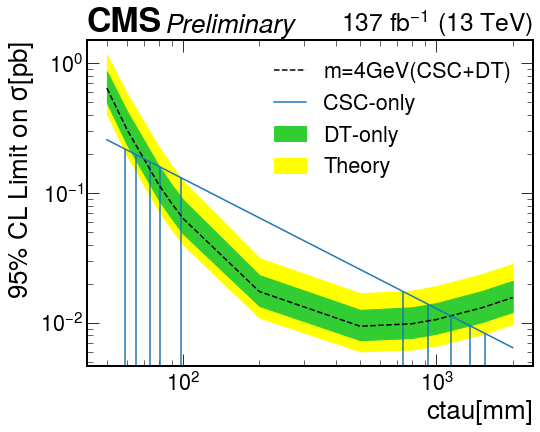

In [5]:
m4GeV_i, ctau4GeV_i, funcs = interpolate1D(arr4GeV, ctau4GeV,-1)
# m4GeV_i, ctau4GeV_i, funcs = interpolate1D(arr4GeV[mask], ctau4GeV[mask],-1)
# m4GeV_i_CSC, ctau4GeV_i_CSC, fx = interpolate1D(arr_4GeV_CSC, ct_4GeV_CSC)
# m4GeV_i_DT, ctau4GeV_i_DT, fx = interpolate1D(arr_4GeV_DT, ct_4GeV_DT)

# ct_xing_4 = intersect(funcs, f_xsec(4),1000)

plt.style.use(hep.style.CMS) 

fig, ax = plt.subplots(figsize=(8,6))

ax = plotlimit(ax,m4GeV_i,ctau4GeV_i,True)
# ax = plotlimit(ax,m4GeV_i_CSC,ctau4GeV_i_CSC,False)
# ax = plotlimit(ax,m4GeV_i_DT,ctau4GeV_i_DT,False)
ax.plot(ctau4GeV_i,f_xsec(4)(ctau4GeV_i),label="Theory")

# ax.get_lines()[1].set_color("blue")
# ax.get_lines()[2].set_color("red")
# ax.plot(ctau_i,f_xsec(4.5)(ctau_i),label="Theory (m=4.5GeV)")

ct_xing_4 = intersect(funcs, f_xsec(4),1000)
ct_xing_4_up = intersect(funcs, f_xsec(4),[70,70,75,70,70])

showXings=True
if showXings:
    for sol in ct_xing_4_up:
        ax.vlines(sol,0,f_xsec(4)(sol))
    for sol in ct_xing_4:
        ax.vlines(sol,0,f_xsec(4)(sol))

showInterPolation=False
if showInterPolation:
    x = np.logspace(1,4,50)
#     x = np.array([55,65,70,80,90])
    x =   ctau4GeV_i
    ax = plotlimit(ax,
                   np.array([funcs[i](x) for i in range(5)]).transpose(),
                   x,True)
    ax.get_lines()[0].set_color('r')
    
ax.set_xlabel("ctau[mm]")
ax.set_ylabel("95% CL Limit on $\sigma$[pb]")
ax.set_yscale("log")
ax.set_xscale("log")
# ax.legend(["m=4GeV","Theory"])
ax.legend(["m=4GeV(CSC+DT)","CSC-only","DT-only","Theory"])

In [8]:
f_xsec(4.5)(np.array(ctau))

array([0.007074 , 0.0014148])

In [8]:
ct_xing_4p5 = intersect(funcs_4p5, f_xsec(4.5),1000)

In [102]:
ctau4p5_i

array([  50.,  100.,  200.,  500.,  800., 1000., 5000.])

/cvmfs/sft.cern.ch/lcg/views/LCG_98python3/x86_64-centos7-gcc9-opt/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/cvmfs/sft.cern.ch/lcg/views/LCG_98python3/x86_64-centos7-gcc9-opt/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


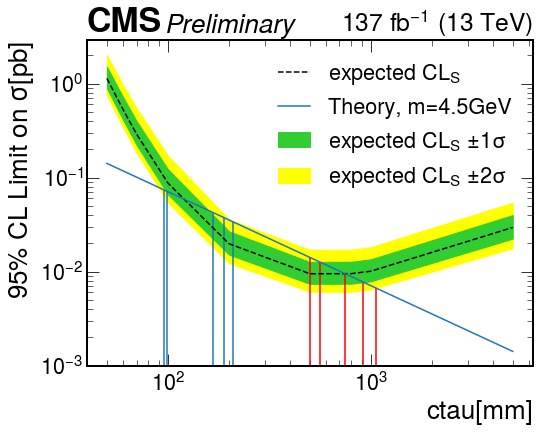

In [6]:
m4p5GeV_i, ctau4p5_i,funcs_4p5 = interpolate1D(arr4p5GeV, ctau4p5GeV,-1)

plt.style.use(hep.style.CMS) 

fig, ax = plt.subplots(figsize=(8,6))
ax = plotlimit(ax,m4p5GeV_i,ctau4p5_i,True)
# ax = plotlimit(ax,m4p5GeV_i,ctau4p5_i,False)
# ax = plotlimit(ax,m4GeV_i,ctau4GeV_i,False)

ax.plot(ctau4p5_i,f_xsec(4.5)(ctau4p5_i),label="Theory, m=4.5GeV")
# ax.plot(ctau4GeV_i,f_xsec(4)(ctau4GeV_i),label="Theory, m=4GeV")

ct_xing_4p5 = intersect(funcs_4p5, f_xsec(4.5),[500,600,700,800,1000])
ct_xing_4p5_up = intersect(funcs_4p5, f_xsec(4.5),[90,100,100,140,150])
# ct_xing_4p5 = intersect(funcs_4p5, f_xsec(4.5),1000)
# ct_xing_4p5_up = intersect(funcs_4p5, f_xsec(4.5),80)


showXings=True
if showXings:
    for sol in ct_xing_4p5_up:
        ax.vlines(sol,0,f_xsec(4.5)(sol))
    for sol in ct_xing_4p5:
        ax.vlines(sol,0,f_xsec(4.5)(sol),color='r')
showInterPolation=False
if showInterPolation:
#     x = np.logspace(1,4,20)
    x = ctau4p5_i
    ax = plotlimit(ax,
                   np.array([funcs_4p5[i](x) for i in range(5)]).transpose(),
                   x,True)
    ax.get_lines()[0].set_color('r')

ax.set_xlabel("ctau[mm]")
ax.set_ylabel("95% CL Limit on $\sigma$[pb]")
ax.set_yscale("log")
ax.set_xscale("log")
# ax.legend(["m=4.5GeV","Theory"])
ax.legend()

/cvmfs/sft.cern.ch/lcg/views/LCG_98python3/x86_64-centos7-gcc9-opt/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/cvmfs/sft.cern.ch/lcg/views/LCG_98python3/x86_64-centos7-gcc9-opt/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


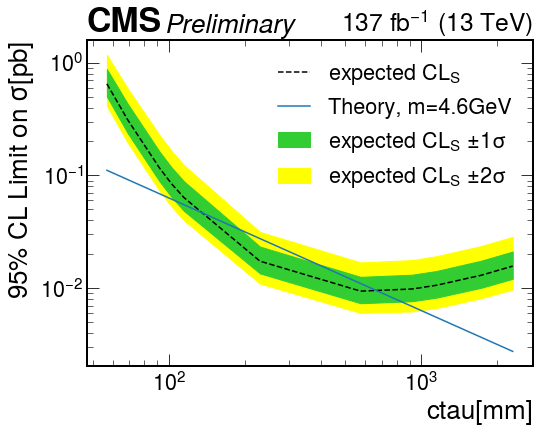

In [95]:
m4p6GeV_i, ctau4p6_i,funcs_4p6 = interpolate1D(arr4p6GeV, ctau4p6GeV,-1)

plt.style.use(hep.style.CMS) 

fig, ax = plt.subplots(figsize=(8,6))
ax = plotlimit(ax,m4p6GeV_i,ctau4p6_i,True)


ax.plot(ctau4p6_i,f_xsec(4.6)(ctau4p6_i),label="Theory, m=4.6GeV")
# ax.plot(ctau4GeV_i,f_xsec(4)(ctau4GeV_i),label="Theory, m=4GeV")

ct_xing_4p6    = intersect(funcs_4p6, f_xsec(4.6),[500,600,700,800,1000])
ct_xing_4p6_up = intersect(funcs_4p6, f_xsec(4.6),[90,100,91,130,140])
# ct_xing_4p6    = intersect(funcs_4p6, f_xsec(4.6),1000)
# ct_xing_4p6_up = intersect(funcs_4p6, f_xsec(4.6),80)

showXings=False
if showXings:
    for sol in ct_xing_4p6_up:
        ax.vlines(sol,0,f_xsec(4.6)(sol))
    for sol in ct_xing_4p6:
        ax.vlines(sol,0,f_xsec(4.6)(sol),color='r')

ax.set_xlabel("ctau[mm]")
ax.set_ylabel("95% CL Limit on $\sigma$[pb]")
ax.set_yscale("log")
ax.set_xscale("log")
ax.legend()

In [39]:
x=np.array([500,800,1000,2000])


In [41]:
m5GeV_i

array([[0.00649002, 0.00791219, 0.01013077, 0.01356321, 0.01821074],
       [0.01630654, 0.01987981, 0.02545411, 0.03417977, 0.04599841]])

In [50]:
intersect(funcs_5, f_xsec(5),500)

/cvmfs/sft.cern.ch/lcg/views/LCG_98python3/x86_64-centos7-gcc9-opt/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


array([ 425.60336991,  330.79666302,  246.89618182, 1000.00270916,
        999.78626074])

In [71]:
f_xsec(5)(800)

0.00519375

In [70]:
funcs_5_2s[1](800)

array(0.01743227)

In [74]:
intersect(funcs_5_2s,f_xsec(5),[200,1000])

/cvmfs/sft.cern.ch/lcg/views/LCG_98python3/x86_64-centos7-gcc9-opt/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


array([356.76643477, 356.76643477])

In [72]:
funcs_5_2s = [funcs_5[0],funcs_5[0]]

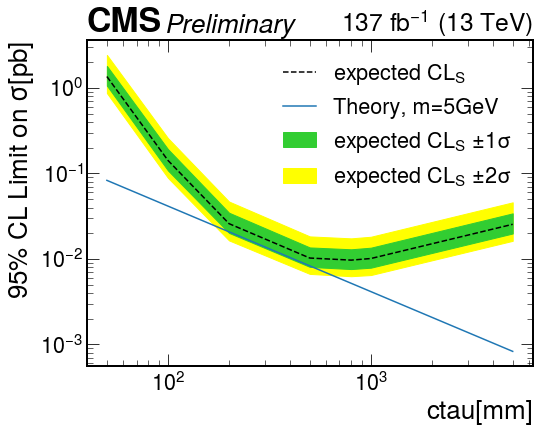

In [7]:
m5GeV_i, ctau5_i,funcs_5 = interpolate1D(arr5GeV, ctau5GeV,-1)

plt.style.use(hep.style.CMS) 

fig, ax = plt.subplots(figsize=(8,6))
ax = plotlimit(ax,m5GeV_i,ctau5_i,True)


ax.plot(ctau5_i,f_xsec(5)(ctau5_i),label="Theory, m=5GeV")

ax.set_xlabel("ctau[mm]")
ax.set_ylabel("95% CL Limit on $\sigma$[pb]")
ax.set_yscale("log")
ax.set_xscale("log")
# ax.legend(["m=4.5GeV","Theory"])
ax.legend()

In [116]:
funcs[0](ctau_i)

array([3.39047357, 0.01656077, 0.01044071, 0.01191657, 0.01612292,
       0.01703012, 0.03862158, 0.07502932])

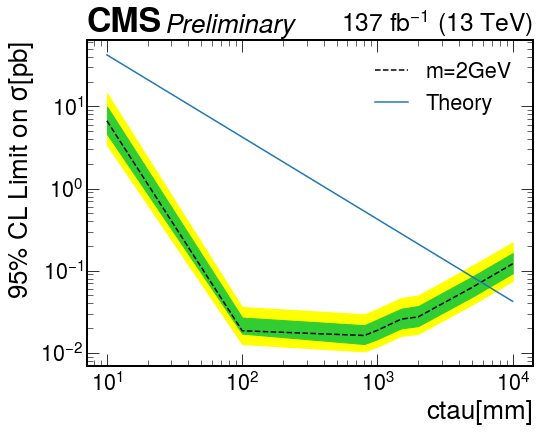

In [8]:
m2GeV_i, ctau_i,funcs_2 = interpolate1D(arr2GeV, ctau2GeV,-1)

plt.style.use(hep.style.CMS) 

fig, ax = plt.subplots(figsize=(8,6))
ax = plotlimit(ax,m2GeV_i,ctau_i,True)
xSection2GeV = 4.2380/(ctau_i/100)
# ax = plotlimit(ax,m7GeV,ctau)

ax.plot(ctau_i,xSection2GeV,label="Theory")

ax.set_xlabel("ctau[mm]")
ax.set_ylabel("95% CL Limit on $\sigma$[pb]")
ax.set_yscale("log")
ax.set_xscale("log")
ax.legend(["m=2GeV","Theory"])

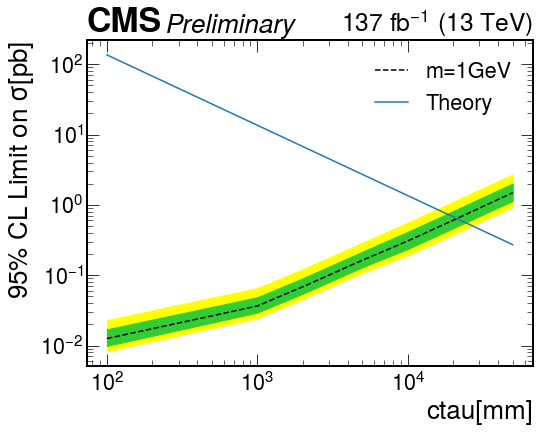

In [62]:
m1GeV_i, ctau_i,funcs_1 = interpolate1D(arr1GeV, ctau1GeV,-1)

plt.style.use(hep.style.CMS) 

fig, ax = plt.subplots(figsize=(8,6))
ax = plotlimit(ax,m1GeV_i,ctau_i,True)
xSection1GeV = 135.7000/(ctau_i/100)

ax.plot(ctau_i,xSection1GeV,label="Theory")

ax.set_xlabel("ctau[mm]")
ax.set_ylabel("95% CL Limit on $\sigma$[pb]")
ax.set_yscale("log")
ax.set_xscale("log")
ax.legend(["m=1GeV","Theory"])

In [66]:
intersect(funcs_5, f_xsec(5),1000)

/cvmfs/sft.cern.ch/lcg/views/LCG_98python3/x86_64-centos7-gcc9-opt/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


array([638.60916944, 515.37408859, 157.71999539, 500.15383467,
       500.20583664])

In [77]:
intersect(funcs_4p5, f_xsec(4.5),70)

/cvmfs/sft.cern.ch/lcg/views/LCG_98python3/x86_64-centos7-gcc9-opt/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


array([ 98.74927804,  99.74152127, 166.27800486, 188.82538815,
       200.29138719])

In [87]:
intersect(funcs, f_xsec(4),70)

array([70.18613339, 73.66922238, 77.14105656, 81.32815172, 98.67298796])

# V^2 v.s. M limit

In [65]:
f_ctau(4)(ct_xing_4_up)

array([5.62789230e-06, 5.36180493e-06, 5.12048989e-06, 4.85686680e-06,
       4.00312191e-06])

In [69]:
f_ctau(4.5)(ct_xing_4p5_up)

array([2.19748442e-06, 2.17562352e-06, 1.30504332e-06, 1.14920987e-06,
       1.08342152e-06])

In [73]:
intersect(funcs_4p5, f_xsec(4.5),120)

/cvmfs/sft.cern.ch/lcg/views/LCG_98python3/x86_64-centos7-gcc9-opt/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


array([129.87721187, 117.72952361, 166.27800486, 387.66628596,
       200.29046625])

In [82]:
ct_xing_4_up

array([58.87874915, 65.22626211, 74.0598239 , 80.81095001, 98.0278493 ])

In [81]:
ct_xing_4p5_up

array([ 95.3903089 ,  98.97617568, 166.2722448 , 188.82314256,
       208.4606492 ])

In [92]:
                   f_ctau(4.5)(ct_xing_4p5)

array([2.03796464e-07, 2.35981137e-07, 2.91265337e-07, 3.88488367e-07,
       4.33444849e-07])

/cvmfs/sft.cern.ch/lcg/views/LCG_98python3/x86_64-centos7-gcc9-opt/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)
/cvmfs/sft.cern.ch/lcg/views/LCG_98python3/x86_64-centos7-gcc9-opt/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/cvmfs/sft.cern.ch/lcg/views/LCG_98python3/x86_64-centos7-gcc9-opt/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
/cvmfs/sft.cern.ch/lcg/views/LCG_98python3/x86_64-centos7-gcc9-opt/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: Runti

(0.7, 7.0)

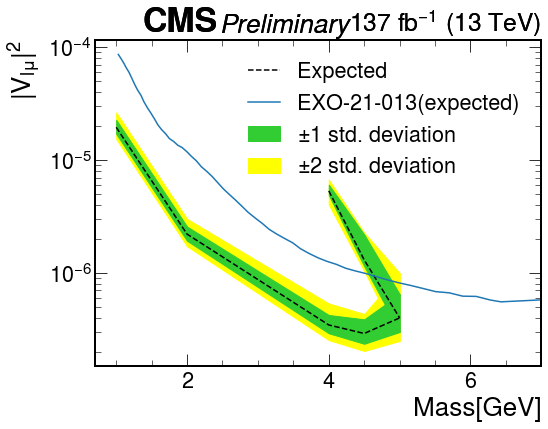

In [94]:
plt.style.use(hep.style.CMS) 

ct_xing_4 = intersect(funcs, f_xsec(4),1000)
ct_xing_1 = intersect(funcs_1, f_xsec(1),20000)
ct_xing_2 = intersect(funcs_2, f_xsec(2),10000)
ct_xing_4p5 = intersect(funcs_4p5, f_xsec(4.5),[500,600,700,800,1000])
ct_xing_4p6    = intersect(funcs_4p6, f_xsec(4.6),[500,600,700,800,1000])

# ct_xing_4p5 = intersect(funcs_4p5, f_xsec(4.5),1000)

ct_xing_5 = np.array([600,500,400,300,100])

EXO = np.genfromtxt("../limit/limit.csv",delimiter=",")

limits = np.array([f_ctau(1)(ct_xing_1),
                   f_ctau(2)(ct_xing_2),
                   f_ctau(4)(ct_xing_4),
                   f_ctau(4.5)(ct_xing_4p5),
#                    f_ctau(4.6)(ct_xing_4p6),                   
#                    f_ctau(5)(ct_xing_5),    
                    np.array([2.5,3,4,6.5,10])*1e-7                   
                  ])
masses = [1,2,4,4.5,5]

fig, ax = plt.subplots(figsize=(8,6))
ax = plotlimit(ax,limits,masses)

# ct_xing_4_up = intersect(funcs, f_xsec(4),70)
ct_xing_4_up = intersect(funcs, f_xsec(4),[70,70,75,70,70])

# ct_xing_4p5_up = intersect(funcs_4p5, f_xsec(4.5),70)
ct_xing_4p5_up = intersect(funcs_4p5, f_xsec(4.5),[90,100,100,140,150])
ct_xing_4p6_up = intersect(funcs_4p6, f_xsec(4.6),[90,100,91,130,140])

limits_up = np.array([f_ctau(4)(ct_xing_4_up),
                   f_ctau(4.5)(ct_xing_4p5_up),
#                    f_ctau(4.6)(ct_xing_4p6_up),    
                    np.array([10,6.5,4,3,2.5])*1e-7                      
                  ])
masses_up = [4,4.5,5]
ax = plotlimit(ax,limits_up,masses_up,True,False)

ax.plot(EXO[:,0],EXO[:,1],label="EXO-21-013(expected)")
ax.legend(["Expected","EXO-21-013(expected)",r"$\pm$1 std. deviation",r"$\pm$2 std. deviation"],loc=1)
ax.set_yscale("log")
ax.set_ylabel("$|V_{l\mu}|^2$")
ax.set_xlabel("Mass[GeV]")
ax.set_xlim(0.7,7)

# ax.set_ylim(1e-6,1e-5)
# ax.set_xlim(3.5,5)

# ax.legend()

In [85]:
ct_xing_4_up

array([58.87874915, 65.22626211, 74.0598239 , 80.81095001, 98.0278493 ])

In [89]:
f_ctau_5=np.array([10,6.5,4,3,2.5])*1e-7

In [88]:
f_ctau(4.5)(ct_xing_4p5_up)

array([2.27486421e-06, 2.19244680e-06, 1.30508853e-06, 1.14922354e-06,
       1.04096385e-06])

In [87]:
f_ctau(4.5)(ct_xing_4p5)

array([2.03796464e-07, 2.35981137e-07, 2.91265337e-07, 3.88488367e-07,
       4.33444849e-07])

In [86]:
ct_xing_4p5_up

array([ 95.3903089 ,  98.97617568, 166.2722448 , 188.82314256,
       208.4606492 ])

# Limit shifting

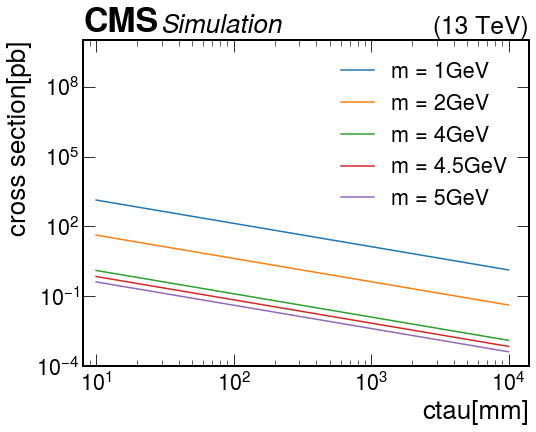

In [97]:
fig, ax = plt.subplots(figsize=(8,6))

x = np.logspace(1,4,40)
ax.plot(x,f_xsec(1)(x)  ,label="m = 1GeV")
ax.plot(x,f_xsec(2)(x)  ,label="m = 2GeV")
ax.plot(x,f_xsec(4)(x)  ,label="m = 4GeV")
ax.plot(x,f_xsec(4.5)(x),label="m = 4.5GeV")
ax.plot(x,f_xsec(5)(x)  ,label="m = 5GeV")
# ax.plot(x,f_xsec(7)(x)  ,label="m = 7GeV")

ax.set_yscale("log")
ax.set_ylim(1e-4,1e10)
ax.set_ylabel("cross section[pb]")

ax.set_xscale("log")
ax.set_xlim(8,None)
ax.set_xlabel("ctau[mm]")

hep.cms.label(ax=ax,label="",data=False)
ax.legend()

In [12]:
from limit.writeABCD import loadhist

In [35]:
data = loadhist('../HNL_histograms_Feb23_muons_signal.pickle')
data_new = loadhist('../HNL_histograms_Mar1_muons_signal.pickle')

/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/coffea/hist/hist_tools.py:581: RuntimeWarning: Reducing along axis <Bin (name=dphi_MET) instance at 0x7fda272e51d0>: requested stop 0.7 between bin boundaries, no interpolation is performed
  RuntimeWarning)
/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/coffea/hist/hist_tools.py:581: RuntimeWarning: Reducing along axis <Bin (name=dphi_MET) instance at 0x7fda2720b5d0>: requested stop 0.7 between bin boundaries, no interpolation is performed
  RuntimeWarning)


HNL_muonType_mHNL10p0_pl100  CSC =  [0.00359853 0.00081236 0.00186075 0.00224878]
HNL_muonType_mHNL10p0_pl100  CSCunc =  [0.00117965 0.00057698 0.00074668 0.00092485]
HNL_muonType_mHNL10p0_pl100  DT =  [0.00035479 0.00123971 0.00072697 0.        ]
HNL_muonType_mHNL10p0_pl100  DTunc =  [0.00035479 0.00066748 0.00051597 0.        ]
HNL_muonType_mHNL10p0_pl1000  CSC =  [0.00155606 0.00299898 0.04092018 0.02005727]
HNL_muonType_mHNL10p0_pl1000  CSCunc =  [0.00024259 0.00034431 0.00124111 0.00086206]
HNL_muonType_mHNL10p0_pl1000  DT =  [0.00190906 0.0030736  0.03573453 0.01922517]
HNL_muonType_mHNL10p0_pl1000  DTunc =  [0.00026887 0.00034204 0.00114695 0.00084027]
HNL_muonType_mHNL10p0_pl10000  CSC =  [2.14890255e-05 7.02892118e-05 1.40010944e-03 5.93212795e-04]
HNL_muonType_mHNL10p0_pl10000  CSCunc =  [8.99522889e-06 1.67764276e-05 7.23698577e-05 4.66472147e-05]
HNL_muonType_mHNL10p0_pl10000  DT =  [0.00011129 0.00013958 0.00152083 0.00068937]
HNL_muonType_mHNL10p0_pl10000  DTunc =  [2.111

HNL_muonType_mHNL7p0_pl100  CSC =  [0.03804715 0.02123373 0.05201338 0.03323407]
HNL_muonType_mHNL7p0_pl100  CSCunc =  [0.00923497 0.00717479 0.0107207  0.00859431]
HNL_muonType_mHNL7p0_pl100  DT =  [0.0135374  0.01267536 0.01290687 0.00190483]
HNL_muonType_mHNL7p0_pl100  DTunc =  [0.00563851 0.00573064 0.00598942 0.00190483]
HNL_muonType_mHNL7p0_pl1000  CSC =  [0.00872521 0.01415912 0.26534225 0.11173698]
HNL_muonType_mHNL7p0_pl1000  CSCunc =  [0.00143237 0.00180031 0.00783434 0.00521883]
HNL_muonType_mHNL7p0_pl1000  DT =  [0.01352161 0.02273869 0.22597267 0.12207775]
HNL_muonType_mHNL7p0_pl1000  DTunc =  [0.00177115 0.00231117 0.00719694 0.0053473 ]
HNL_muonType_mHNL7p0_pl10000  CSC =  [7.08683026e-05 2.55107876e-04 6.31911223e-03 2.74019036e-03]
HNL_muonType_mHNL7p0_pl10000  CSCunc =  [3.91859509e-05 7.58861643e-05 3.86653499e-04 2.46245715e-04]
HNL_muonType_mHNL7p0_pl10000  DT =  [0.00035585 0.00089646 0.00681009 0.0025811 ]
HNL_muonType_mHNL7p0_pl10000  DTunc =  [8.60084654e-05 1.

/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/coffea/hist/hist_tools.py:581: RuntimeWarning: Reducing along axis <Bin (name=dphi_MET) instance at 0x7fda27172690>: requested stop 0.7 between bin boundaries, no interpolation is performed
  RuntimeWarning)
/uscms/home/kkwok/work/LLP/CMSSW_10_6_20/src/llp_analyzer/coffeaenv/lib/python3.7/site-packages/coffea/hist/hist_tools.py:581: RuntimeWarning: Reducing along axis <Bin (name=dphi_MET) instance at 0x7fda274a9410>: requested stop 0.7 between bin boundaries, no interpolation is performed
  RuntimeWarning)


HNL_muonType_mHNL1p0_pl10000  CSC =  [ 0.          2.25792804 12.5938797   3.91385083]
HNL_muonType_mHNL1p0_pl10000  CSCunc =  [0.         1.00551897 2.53580374 1.47521774]
HNL_muonType_mHNL1p0_pl10000  DT =  [ 0.54224782  1.20117507 13.53483871  7.56249241]
HNL_muonType_mHNL1p0_pl10000  DTunc =  [0.54224782 0.7720664  2.73000213 2.01023072]
HNL_muonType_mHNL1p0_pl10000_rwctau20000  CSC =  [0.         0.58674456 3.23417357 0.98425379]
HNL_muonType_mHNL1p0_pl10000_rwctau20000  CSCunc =  [0.         0.25770072 0.65257775 0.37097049]
HNL_muonType_mHNL1p0_pl10000_rwctau20000  DT =  [0.13650751 0.3022155  3.412853   1.90518924]
HNL_muonType_mHNL1p0_pl10000_rwctau20000  DTunc =  [0.13650751 0.19434147 0.68829243 0.50644394]
HNL_muonType_mHNL1p0_pl10000_rwctau50000  CSC =  [0.         0.0962575  0.52797146 0.15803935]
HNL_muonType_mHNL1p0_pl10000_rwctau50000  CSCunc =  [0.         0.04194423 0.10732037 0.05956432]
HNL_muonType_mHNL1p0_pl10000_rwctau50000  DT =  [0.02193248 0.04854013 0.548874

In [36]:
data_all = {**data, **data_new}

In [15]:
arr_src = data["HNL_muonType_mHNL2p0_pl1000"]
arr_new = data["HNL_muonType_mHNL4p0_pl2000"]

In [30]:
# Find the corresponding yield of (m,ct)-> (m,xx)
def shift_ctau(N_yield,m_old,ct_old,m_new):
    ct_new = (m_new/m_old) * ct_old
    return N_yield * f_xsec(m_new)(ct_new)/f_xsec(m_old)(ct_old)

In [22]:
print("source (2,1000) -> ct_new = (4,2000)")
print("shifted Yield at 4 (ct,yield)= ",shift_ctau(arr_src["CSC"],2,1000,4))
print("Gen Yield at 4 (ct,yield)   = ",arr_new["CSC"])

source (2,1000) -> ct_new = (4,2000)
shifted Yield at 4 (ct,yield)=  (2000.0, array([0.01961549, 0.09396908, 1.33021062, 0.38321582]))
Gen Yield at 4 (ct,yield)   =  [0.03388892 0.07544135 1.28896805 0.44779054]


In [46]:

out = {}
for sample, arr in data_all.items():
    mass = float(sample.split("_")[2].replace("mHNL","").replace("p","."))
    ct = float(sample.split("_")[-1].replace("pl",""))
#     print(sample,mass,ct)
    if mass == 4:
        ct_new = (4.6/4) * ct
        name = "HNL_muonType_mHNL4p6_pl%s"%str(np.round(ct_new)).replace(".0","")
#         print(name)
#         print(ct,np.round(ct_new),shift_ctau(arr['CSC'],4,ct,4.6),shift_ctau(arr['DT'],4,ct,4.6))        
        out[name]={"CSC":shift_ctau(arr['CSC'],4,ct,4.6),"DT":shift_ctau(arr['DT'],4,ct,4.6),"norm":1}

        ct_new = (4.7/4) * ct
        name = "HNL_muonType_mHNL4p7_pl%s"%str(np.round(ct_new)).replace(".0","")
#         print(name)
#         print(ct,np.round(ct_new),shift_ctau(arr['CSC'],4,ct,4.6),shift_ctau(arr['DT'],4,ct,4.6))        
        out[name]={"CSC":shift_ctau(arr['CSC'],4,ct,4.7),"DT":shift_ctau(arr['DT'],4,ct,4.7),"norm":1}
    

In [47]:
np.array([ 2.62177929,  6.13920546 ,68.80480406 ,22.27152984])*f_xsec(4)(2000)/f_xsec(2)(1000)

array([0.03987109, 0.09336286, 1.04635904, 0.33869752])

In [176]:
np.array([funcs_4p5[i](ctau4p5_i) for i in range(5)]).transpose()

array([[0.744304  , 0.88746363, 1.13418693, 1.50943563, 2.01705135],
       [0.05557461, 0.06771892, 0.08934999, 0.12515743, 0.17465343],
       [0.01231115, 0.01518547, 0.0198216 , 0.02685758, 0.03613448],
       [0.00611095, 0.00740124, 0.00948149, 0.0126563 , 0.01701619],
       [0.00608535, 0.00741882, 0.00949907, 0.01271747, 0.01707523],
       [0.00646142, 0.00787734, 0.01008617, 0.01350351, 0.01819761],
       [0.01772846, 0.02240592, 0.02946859, 0.03992225, 0.05409001]])

In [ ]:
HNL_muonType_mHNL4p0_pl1000  CSC =  [0.11367208 0.23031757 3.90969984 1.4149658 ]
HNL_muonType_mHNL4p0_pl1000  CSCunc =  [0.02164984 0.03040493 0.12421057 0.07470873]
HNL_muonType_mHNL4p0_pl1000  DT =  [0.16994022 0.33335487 3.38758482 1.77729034]
HNL_muonType_mHNL4p0_pl1000  DTunc =  [0.02624798 0.0368833  0.11577296 0.08361854]

HNL_muonType_mHNL2p0_pl1000  CSC =  [ 2.62177929  6.13920546 68.80480406 22.27152984]
HNL_muonType_mHNL2p0_pl1000  CSCunc =  [0.60830265 0.93177423 3.03868897 1.70702759]
HNL_muonType_mHNL2p0_pl1000  DT =  [ 4.84003038  4.08741815 62.3940202  39.06735284]
HNL_muonType_mHNL2p0_pl1000  DTunc =  [0.83350767 0.71749561 2.83141488 2.26752986]

HNL_muonType_mHNL4p0_pl1000_rwctau2000  CSC =  [0.03388892 0.07544135 1.28896805 0.44779054]
HNL_muonType_mHNL4p0_pl1000_rwctau2000  CSCunc =  [0.00650413 0.00998909 0.04118466 0.02370531]
HNL_muonType_mHNL4p0_pl1000_rwctau2000  DT =  [0.05441054 0.11464907 1.18446408 0.60551109]
HNL_muonType_mHNL4p0_pl1000_rwctau2000  DTunc =  [0.00854235 0.01282545 0.04067794 0.02857033]

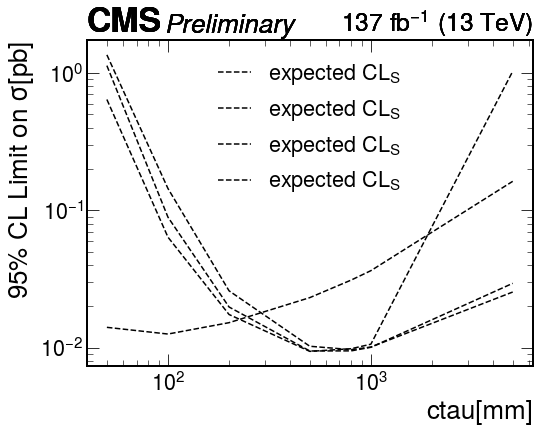

In [33]:
m4p5GeV_i, ctau4p5_i,funcs_4p5 = interpolate1D(arr4p5GeV, ctau4p5GeV,-1)

plt.style.use(hep.style.CMS) 

fig, ax = plt.subplots(figsize=(8,6))
# ax = plotlimit(ax,m4p5GeV_i,ctau4p5_i,True)
ax = plotlimit(ax,
               np.array([funcs_4p5[i](ctau4p5_i) for i in range(5)]).transpose(),
               ctau4p5_i,False)
ax = plotlimit(ax,
               np.array([funcs[i](ctau4p5_i) for i in range(5)]).transpose(),
               ctau4p5_i,False)

ax = plotlimit(ax,
               np.array([funcs_5[i](ctau4p5_i) for i in range(5)]).transpose(),
               ctau4p5_i,False)
ax = plotlimit(ax,
               np.array([funcs_1[i](ctau4p5_i) for i in range(5)]).transpose(),
               ctau4p5_i,False)

# ax = plotlimit(ax,m4p5GeV_i,ctau4p5_i,False)
# ax = plotlimit(ax,m4GeV_i,ctau4GeV_i,False)

# ax.plot(ctau4p5_i,f_xsec(4.5)(ctau4p5_i),label="Theory, m=4.5GeV")
# ax.plot(ctau4GeV_i,f_xsec(4)(ctau4GeV_i),label="Theory, m=4GeV")

ax.set_xlabel("ctau[mm]")
ax.set_ylabel("95% CL Limit on $\sigma$[pb]")
ax.set_yscale("log")
ax.set_xscale("log")
# ax.legend(["m=4.5GeV","Theory"])
ax.legend()

# 2D limits

In [17]:
def interpolate2D(combineLimits,x,y,nBins=10):
    epsilon = 0.2
    smooth = 1
    newLimits = []
#     xi = np.linspace(min(x),max(x),nBins)
    if nBins<0:
        xi = x
        yi = y
    else:
        xi = np.logspace(np.log10(min(x)),np.log10(max(x)),nBins)    

    for i in range(5):
        z = combineLimits[:,i]
        rbfi = Rbf(x,y,z,function='multiquadric', epsilon=epsilon,smooth=smooth)
#         rbfi = Rbf(x,y,function='cubic', epsilon=epsilon,smooth=smooth)
        myXI, myYI = np.meshgrid(xi,yi)
        zi = rbfi(myXI,myYI)
        newLimits.append(zi)
    newLimits = np.array(newLimits).transpose()
    return newLimits, myXI,myYI

In [18]:
x= np.concatenate([np.ones_like(ctau4GeV)*4,2*np.ones_like(ctau2GeV)],axis=0)

In [19]:
y=np.concatenate([ctau4GeV,ctau2GeV],axis=0)

In [22]:
z = np.concatenate([arr4GeV,arr2GeV],axis=0)

In [27]:
z[:,3]

array([ 0.01318735,  0.01260592,  0.02334118,  0.16329081,  0.08882983,
        0.0142238 ,  0.02108977,  0.86800341,  0.0175409 ,  0.0438945 ,
        0.02175238,  0.02693847,  0.03453834, 10.01427176,  0.02558645])

In [59]:
h = hist.Hist("Expected Limit",
         hist.Bin("ct","ctau[mm]",np.logspace(0,np.log(max(y)),len(y)+1)),
         hist.Bin("m",'mass[GeV]',5,0,5)
        )
h.fill(ct = y,m=x, weight=z[:,2])

In [46]:
z[:,2]

array([0.00985002, 0.00941574, 0.01743423, 0.11675269, 0.06369473,
       0.01062418, 0.01565934, 0.6445    , 0.01302427, 0.03259204,
       0.01629602, 0.01862402, 0.02579772, 6.68395508, 0.01883096])

In [50]:
import matplotlib

(1, 10000.0)

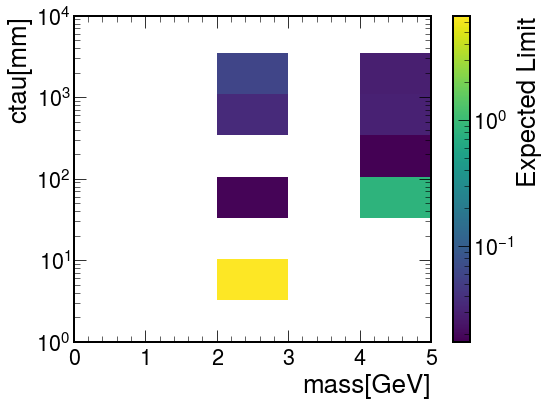

In [60]:
plt.style.use(hep.style.CMS) 

fig, ax = plt.subplots(figsize=(8,6))

hist.plot2d(h,xaxis="m",ax=ax,patch_opts={"norm":matplotlib.colors.LogNorm()})

ax.set_yscale("log")
ax.set_ylim(1,1e4)

In [272]:
zi, xi,yi = interpolate2D(z,x,y,-1)

In [293]:
z = zi[:,:,3]

In [294]:
z.shape

(15, 15)

In [288]:
xi.shape

(15, 15)

In [83]:
arr3*3.95E-06

array([2.23513489e-06, 3.06877310e-06, 4.50546875e-06, 6.73238354e-06,
       9.48151189e-06, 2.66952109e-03])

## Rbf (radial basis function interpolation)

In [3]:
from scipy.interpolate import Rbf
import numpy as np

In [66]:
rng = np.random.default_rng()
# x = rng.random((1, 50))
x = np.random.normal(size=50)
y = x*x
rbfi = Rbf(x,y)  # radial basis function interpolator instance
xi = np.linspace(0, 1, 20)
yi = rbfi(xi)   # interpolated values
yi.shape

(20,)

In [82]:
m4GeV[:,1]

array([0.49633659, 0.04855246, 0.00791557])

In [84]:
m4GeV.transpose()[1]

array([0.49633659, 0.04855246, 0.00791557])

In [ ]:
def interpolate1D(combineLimits,x):
    rbfi = Rbf(x,y, )